<a id="id2"></a> <br> 
# 1. Get the Data (Collect / Obtain)

## All imports used in this kernel

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML
import pickle

# alt.renderers.enable('notebook')

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

## All function used in this kernel

In [3]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """
    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [4]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                verbose=verbose, early_stopping_rounds=early_stopping_rounds)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if plot_feature_importance:
        feature_importance["importance"] /= folds.n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

        result_dict['feature_importance'] = feature_importance
        
    return result_dict

<a id="id3"></a> <br> 
# 2. Load the Dataset

Let's load all necessary datasets

In [5]:
from pathlib import Path

INPUT = Path("./data")
OPEN_BABEL = Path("./data")
CUSTOM = Path("./data")
CSV_TRAIN = INPUT / "train.csv"
CSV_TEST = INPUT / "test.csv"
CSV_SUBMISSION = INPUT / "sample_submission.csv"
CSV_DIPOLE_MOMENTS = INPUT / "dipole_moments.csv"
CSV_MAGNETIC_SHIELDING_TENSORS = INPUT / "magnetic_shielding_tensors.csv"
CSV_MULLIKEN_CHARGES = INPUT / "mulliken_charges.csv"
CSV_POTENTIAL_ENERGY = INPUT / "potential_energy.csv"
CSV_SCALAR_COUPLING_CONTRIBUTIONS = INPUT / "scalar_coupling_contributions.csv"
CSV_STRUCTURES = INPUT / "structures.csv"
CSV_TRAIN_CHARGES = OPEN_BABEL / "train_ob_charges.csv"
CSV_TEST_CHARGES = OPEN_BABEL / "test_ob_charges.csv"
CSV_DAIJ2 = CUSTOM / "daij2.csv"
CSV_NEIBORS_DIST = CUSTOM / "neibors_dist_df.csv"
CSV_DIST_FEATURES = CUSTOM / "dist_features.csv"
CSV_LINK = CUSTOM / "link_info.csv"
CSV_ATOM_INFO = CUSTOM / "dist_atom_info.csv"
CSV_RADIUS_BASED_INFO = CUSTOM / "radius_based_info.csv"

In [6]:
n_estimators_default = 4000

In [7]:
train = pd.read_csv("./train_add_features_20190808.csv")
test = pd.read_csv("./test_add_features_20190808.csv")

# Neigbors dist

In [8]:
# def read_pickle(path):
#     with open(path, "rb") as f:
#         obj = pickle.load(f)
#     return obj


# def write_pickle(obj, path):
#     with open(path, "wb") as f:
#         pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# train_negibors_dist = read_pickle("./data/train_relative_dist.pkl")
# test_negibors_dist = read_pickle("./data/test_relative_dist.pkl")

In [10]:
# test_negibors_dist.columns

In [11]:
# train_negibors_dist = train_negibors_dist.drop(["scalar_coupling_constant"], axis=1)

In [12]:
# train["molecule_index"] = train.molecule_name.str.replace("dsgdb9nsd_", "").astype("int32")
# train = train.drop("molecule_name", axis=1)

# test["molecule_index"] = test.molecule_name.str.replace("dsgdb9nsd_", "").astype("int32")
# test = test.drop("molecule_name", axis=1)

In [13]:
# train = pd.merge(train, train_negibors_dist, how='left', on=["molecule_index", "atom_index_0", "atom_index_1"])
# del train_negibors_dist
# gc.collect()

In [14]:
# test = pd.merge(test, test_negibors_dist, how='left', on=["molecule_index", "atom_index_0", "atom_index_1"])
# del test_negibors_dist
# gc.collect()

# QM7

In [15]:
qm7 = pd.read_csv("./data/struct_eigen.csv")
qm7["molecule_index"] = qm7.molecule_name.str.replace("dsgdb9nsd_", "").astype("int32")
qm7 = qm7.drop("molecule_name", axis=1)

In [16]:
qm7.head()

atom_index  connectedness        coulomb_mean            eigv_gap  \
0           0              1  11.767428118975554  39.986769787095547   
1           1              1   1.535433167386762  39.986769787095540   
2           2              1   1.535434499359120  39.986769787095547   
3           3              1   1.535438060649547  39.986769787095540   
4           4              1   1.535436895839784  39.986769787095540   

             eigv_max           eigv_min        fiedler_eig  \
0  40.047568400141436  0.060798613045888  1.506037725597210   
1  40.047568400141429  0.060798613045888  1.506037725597209   
2  40.047568400141436  0.060798613045888  1.506037725597209   
3  40.047568400141429  0.060798613045888  1.506037725597211   
4  40.047568400141429  0.060798613045888  1.506037725597210   

                sv_0               sv_1               sv_2               sv_3  \
0  29.41613156383649  0.060815698036764  0.060805119009877  0.060798614452167   
1  29.41613156383649  0.060815698036764  0.060805119009877  0.060798614452167   
2  29.41613156383648  0.060815698036764  0.060805119009877  0.060798614452167   
3  29.41613156383649  0.060815698036764  0.060805119009878  0.060798614452167   
4  29.41613156383649  0.060815698036764  0.060805119009877  0.060798614452167   

                    sv_4             sv_min  molecule_index  
0  8.946912303221812e-16  0.060798614452167               1  
1  6.410361303934512e-16  0.060798614452167               1  
2  2.030442975809136e-17  0.060798614452167               1  
3  3.549286171304484e-16  0.060798614452167               1  
4  7.166480073202293e-16  0.060798614452167               1

In [17]:
def map_qm7_info(df, atom_idx):
    df = pd.merge(df, qm7, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'connectedness': f'connectedness_{atom_idx}',
                            'coulomb_mean': f'coulomb_mean_{atom_idx}',
                            'eigv_gap': f'eigv_gap_{atom_idx}',
                            'eigv_max': f'eigv_max_{atom_idx}',
                            'eigv_min': f'eigv_min_{atom_idx}',
                            'fiedler_eig': f'fiedler_eig_{atom_idx}',
                            'sv_0': f'sv_0_{atom_idx}',
                            'sv_1': f'sv_1_{atom_idx}',
                            'sv_2': f'sv_2_{atom_idx}',
                            'sv_3': f'sv_3_{atom_idx}',
                            'sv_4': f'sv_4_{atom_idx}',
                            'sv_min': f'sv_min_{atom_idx}'
                           })
    return df

In [18]:
train = map_qm7_info(train, 0)
train = map_qm7_info(train, 1)

test = map_qm7_info(test, 0)
test = map_qm7_info(test, 1)

In [19]:
del qm7
gc.collect()

98

## Preprocess after creating features

In [20]:
# train = pd.read_csv("./train_add_features_20190805.csv")
# test = pd.read_csv("./test_add_features_20190805.csv")

In [21]:
# scalar_coupling_contributions = pd.read_csv(CSV_SCALAR_COUPLING_CONTRIBUTIONS)

# train = pd.merge(train, scalar_coupling_contributions, how = 'left',
#                   left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
#                   right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
                  
# del scalar_coupling_contributions
# gc.collect()

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 7982.91 Mb (74.6% reduction)
Mem. usage decreased to 4246.09 Mb (74.6% reduction)


In [23]:
train.to_csv("train_add_features_20190815.csv")
test.to_csv("test_add_features_20190815.csv")

In [24]:
pd.set_option('display.max_rows', 600)

In [25]:
del_cols_list = ['id','molecule_index', 'sd_x','pso_x','dso_x']
def del_cols(df, cols):
    del_cols_list_ = [l for l in del_cols_list if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

train = del_cols(train,del_cols_list)
test = del_cols(test,del_cols_list)

In [26]:
def encode_categoric_single(df):
    lbl = LabelEncoder()
    cat_cols=[]
    try:
        cat_cols = df.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            df[cat] = lbl.fit_transform(list(df[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    return df

In [27]:
def encode_categoric(dtrain,dtest):
    lbl = LabelEncoder()
    objs_n = len(dtrain)
    dfmerge = pd.concat(objs=[dtrain,dtest],axis=0)
    cat_cols=[]
    try:
        cat_cols = dfmerge.describe(include=['O']).columns.tolist()
        for cat in cat_cols:
            dfmerge[cat] = lbl.fit_transform(list(dfmerge[cat].values))
    except Exception as e:
        print('error: ', str(e) )

    dtrain = dfmerge[:objs_n]
    dtest = dfmerge[objs_n:]
    return dtrain,dtest

In [28]:
train = encode_categoric_single(train)
test = encode_categoric_single(test)

In [29]:
y_fc = train['fc_x']
X = train.drop(['scalar_coupling_constant','fc_x'],axis=1)
y = train['scalar_coupling_constant']

X_test = test.copy()

In [30]:
print('X size',X.shape)
print('X_test size',X_test.shape)
print('dtest size',test.shape)
print('y_fc size',y_fc.shape)

del train, test
gc.collect()


X size (4658147, 878)
X_test size (2505542, 874)
dtest size (2505542, 874)
y_fc size (4658147,)


35

In [31]:
X.iloc[:100].to_csv("sample.csv")

In [35]:
X = X.drop(["fc_y", "sd_y", "pso_y", "dso_y"], axis=1)

## Check features importance
I use top 200 features of lgb importance result.

In [32]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [33]:
params = {'num_leaves': 50,
          'min_child_samples': 79,
          'min_data_in_leaf' : 100,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

Fold 1 started at Thu Aug 15 21:27:04 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.615197	valid_1's l1: 0.631133
[1000]	training's l1: 0.52067	valid_1's l1: 0.548478
[1500]	training's l1: 0.469561	valid_1's l1: 0.507603
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.469561	valid_1's l1: 0.507603
Fold 2 started at Thu Aug 15 23:08:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.613994	valid_1's l1: 0.631553
[1000]	training's l1: 0.520698	valid_1's l1: 0.549687
[1500]	training's l1: 0.46834	valid_1's l1: 0.50741
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.46834	valid_1's l1: 0.50741
Fold 3 started at Fri Aug 16 00:46:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.612163	valid_1's l1: 0.629757
[1000]	training's l1: 0.51799	valid_1's l1: 0.547281
[1500]	training's l1: 0.465396	valid_1's l1: 0.504391
D

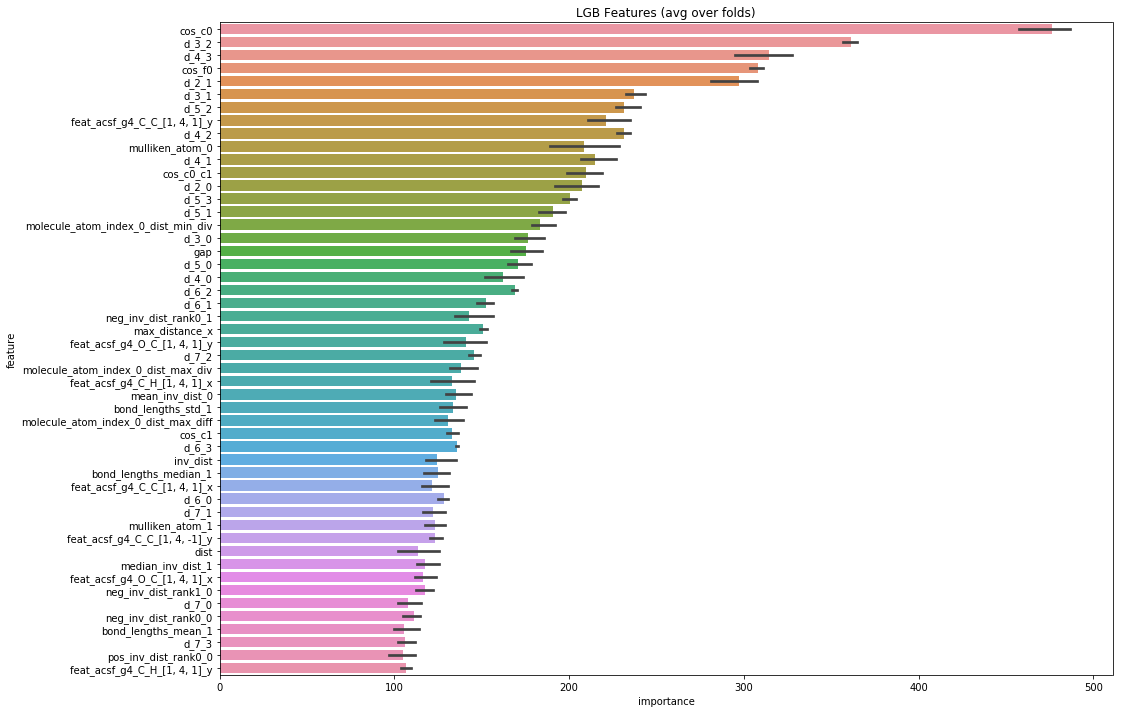

In [36]:
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=1500)

In [37]:
result_dict_lgb["feature_importance"].groupby("feature").mean().sort_values("importance", ascending=False).to_csv("result_dict_lgb.csv")

In [ ]:
# X = X.drop(['fc_y', 'sd_y', 'pso_y', 'dso_y'], axis=1)